# An optimization problem in the Brazilian flight data

## 1. Introduction

The Brazilian flight data shared by their Civil Aviation Authority (ANAC) brings some airline marketing metrics, and also variables that enables one to recalculate these metrics. While testing for the consistency of these values, I have arrived at a model optimization problem: what is the average weight for passengers that airlines use for their flight plans? Are they the same for Brazilian and foreign airlines?

Let's check it out.

The data used in this notebook may be found at:

- https://www.gov.br/anac/pt-br/assuntos/dados-e-estatisticas/dados-estatisticos/arquivos/resumo_anual_2019.csv
- https://www.gov.br/anac/pt-br/assuntos/dados-e-estatisticas/dados-estatisticos/arquivos/resumo_anual_2020.csv
- https://www.gov.br/anac/pt-br/assuntos/dados-e-estatisticas/dados-estatisticos/arquivos/resumo_anual_2021.csv

## 2. Importing the libraries and data clean-up

NOTE: this section #2 is exactly the same found in the EDA article below:

# LINK FOR ARTICLE

If you have already read it, you can skip this section.

First of all, let's import the libraries we are going to use:

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import unidecode

I am using the Seaborn library instead of matplotlib. I am also using the unidecode library to convert the column names to a more friendly format.

Now the files are loaded and merged into a single dataframe.

In [2]:
folder = r'C:\Users\thiag\data\ANAC-transport'

dffiles = ['resumo_anual_2019.csv',
         'resumo_anual_2020.csv',
         'resumo_anual_2021.csv']

df = pd.concat([pd.read_csv(os.path.join(folder, x),
                            sep=';', encoding=('ISO-8859-1'))
                for x in dffiles])

Let's look at the data.

In [3]:
print(df.head())

  EMPRESA (SIGLA) EMPRESA (NOME) EMPRESA (NACIONALIDADE)   ANO  MÊS  \
0             AAF     AIGLE AZUR             ESTRANGEIRA  2019    1   
1             AAF     AIGLE AZUR             ESTRANGEIRA  2019    1   
2             AAF     AIGLE AZUR             ESTRANGEIRA  2019    2   
3             AAF     AIGLE AZUR             ESTRANGEIRA  2019    2   
4             AAF     AIGLE AZUR             ESTRANGEIRA  2019    3   

  AEROPORTO DE ORIGEM (SIGLA) AEROPORTO DE ORIGEM (NOME)  \
0                        LFPO          ORLY (NEAR PARIS)   
1                        SBKP                   CAMPINAS   
2                        LFPO          ORLY (NEAR PARIS)   
3                        SBKP                   CAMPINAS   
4                        LFPO          ORLY (NEAR PARIS)   

  AEROPORTO DE ORIGEM (UF) AEROPORTO DE ORIGEM (REGIÃO)  \
0                      NaN                          NaN   
1                       SP                      SUDESTE   
2                      NaN         

The following can be observed about the column names:
- They are written in Portuguese and contain accentuation;
- They are all in upper case letters;
- They contain spaces and parenthesis.

To facilitate readability we will modify the column names by:
- Replacing the spaces with underlines "_";
- Removing the parenthesis;
- Making all letters lowercase; and
- Removing the accents.
This convention is called snake_case and, even though not standard, it is frequently used. For more information, refer to: https://en.wikipedia.org/wiki/Snake_case

In [4]:
print("Column names before changes:\n")
print(df.columns)

df.columns = [unidecode.unidecode(z.lower())
              .replace(' ','_')
              .replace('(','')
              .replace(')','') 
              for z in df.columns]

df.to_csv('3years.csv', sep=';', index=False)

print("Column names after changes:\n")

print(df.columns)

Column names before changes:

Index(['EMPRESA (SIGLA)', 'EMPRESA (NOME)', 'EMPRESA (NACIONALIDADE)', 'ANO',
       'MÊS', 'AEROPORTO DE ORIGEM (SIGLA)', 'AEROPORTO DE ORIGEM (NOME)',
       'AEROPORTO DE ORIGEM (UF)', 'AEROPORTO DE ORIGEM (REGIÃO)',
       'AEROPORTO DE ORIGEM (PAÍS)', 'AEROPORTO DE ORIGEM (CONTINENTE)',
       'AEROPORTO DE DESTINO (SIGLA)', 'AEROPORTO DE DESTINO (NOME)',
       'AEROPORTO DE DESTINO (UF)', 'AEROPORTO DE DESTINO (REGIÃO)',
       'AEROPORTO DE DESTINO (PAÍS)', 'AEROPORTO DE DESTINO (CONTINENTE)',
       'NATUREZA', 'GRUPO DE VOO', 'PASSAGEIROS PAGOS', 'PASSAGEIROS GRÁTIS',
       'CARGA PAGA (KG)', 'CARGA GRÁTIS (KG)', 'CORREIO (KG)', 'ASK', 'RPK',
       'ATK', 'RTK', 'COMBUSTÍVEL (LITROS)', 'DISTÂNCIA VOADA (KM)',
       'DECOLAGENS', 'CARGA PAGA KM', 'CARGA GRATIS KM', 'CORREIO KM',
       'ASSENTOS', 'PAYLOAD', 'HORAS VOADAS', 'BAGAGEM (KG)'],
      dtype='object')
Column names after changes:

Index(['empresa_sigla', 'empresa_nome', 'empresa_nacio

This looks better.
Let's add some new columns to this dataframe, to support our analysis:
- Since we are looking for a cronologic observation, it is insteresting to concatenate the calendar months and years into a single variable called 'data' (Portuguese for date. I am keeping Portuguese names for consistency). Let's also add a column named 'quarto' (Portuguese for quarter) to concatenate variables around the months of the year 3-by-3.
- We can also infer the routes from the origin and destination airport variables (respectivelly called aeroporto_de_origem_sigla and aeroporto_de_destino_sigla). A variable named 'rota' (Portuguese for route) will be created to store the 'origin->destination' string. Another variable with the names of the airports (instead of the codes) will be created (and alled 'rota_nome') for readability (not everyone knows all airport codes).
- Dividing RPK for ASK we get the load factor, which is a very important metric for airlines economics. This variable will also be created.


In [5]:
df['data'] = [str(x['ano']) + '-' + "{:02}".format(x['mes'])
              for index, x in df.iterrows()]

df['rota'] = [str(x['aeroporto_de_origem_sigla']) + '->' +
              str(x['aeroporto_de_destino_sigla'])
              for index, x in df.iterrows()]

df['rota_nome'] = [str(x['aeroporto_de_origem_nome']) + '->' +
              str(x['aeroporto_de_destino_nome'])
              for index, x in df.iterrows()]

df['load_factor'] = df['rpk']/df['ask']

def quarter(x):
    year = x['ano']
    mes = x['mes']
    if mes in [1, 2, 3]:
        quarter = str(year) + '-Q1' 
    elif mes in [4, 5, 6]:
        quarter = str(year) + '-Q2' 
    elif mes in [7, 8, 9]:
        quarter = str(year) + '-Q3' 
    elif mes in [10, 11, 12]:
        quarter = str(year) + '-Q4' 
    return quarter

df['quarter'] = df.apply(quarter, axis=1)

## 3. Airline metrics for efficiency and capacity

Since there is no data dictionary, it is now a good time to talk about some interesting variables:
- RPK meaning "Revenue Passenger Kilometers" is an air transport industry metric that aggregates the number of paying passengers and the quantity of kilometers traveled by them. It is calculated by multiplying the number of paying passengers by the distance traveled in kilometers.
- ASK meaning "Available Seat Kilometers" is similar to the RPK but instead of using the paying passengers, the passenger capacity (number of seats available in the aircraft) is multiplied by the traveled distance.
- RTK (for "Revenue tonne kilometres") measures the revenue cargo load in tonnes multiplied by the distance flown in kilometers.
- ATK (for "Available tonne kilometres") measures the aircraft capacity of cargo load in tonnes multiplied by the distance flown in kilometers.

The dataframe presents not only the value of these parameters but also the variables that compose their formula. Therefore, let's make a consistency check, verifying it is possible to reproduce their values through the variables.

The formulas of the variables are:

$ RPK = \frac{\sum{PayingPassengers} \ \times \ distance}{\sum{flights}} $

$ ASK = \frac{\sum{Seats} \ \times \ distance}{\sum{flights}} $

$ RTK = \frac{(AvgWeight \ \times \ \sum{PayingPassengers \ + \ BaggageWeight \ + \ CargoWeight \ + \ MailWeight)  } \ \times \ distance}{1000 \ \times \ \sum{flights}} $

$ ASK = \frac{\sum{Payload} \ \times \ distance}{1000 \ \times \ \sum{flights}} $

The only variable not given in our data set is the AvgWeight variable. How about we calculate the AvgWeight that gives the best difference between the given RTK and the calculated RTK?

This is an optimization problem that we will define below:

$$\min_{AvgWeight} RTK_{given} - \frac{(AvgWeight \ \times \ \sum{PayingPassengers \ + \ BaggageWeight \ + \ CargoWeight \ + \ MailWeight)  } \ \times \ distance}{1000 \ \times \ \sum{flights}} $$

Let's define the optimization function (with some margin of error) and use the library Scipy to optimize this problem.

In [6]:
def matching(k):
    dummy = []
    for index, x in df.iterrows():
        if x['decolagens'] == 0:
            dummy.append(abs(x['rtk']) < 1000)
        else:
            dummy.append(abs(x['rtk'] - (k*x['passageiros_pagos']+x['carga_paga_kg']+x['correio_kg']+x['bagagem_kg'])*x['distancia_voada_km']/
                             (1000*x['decolagens'])) < 1000)
    return 1/sum(dummy)

from scipy import optimize

res = optimize.minimize_scalar(matching, bounds=(70,150), method='bounded',
                                options={'maxiter':100})

print(res)

     fun: 2.477700693756194e-05
 message: 'Solution found.'
    nfev: 25
  status: 0
 success: True
       x: 75.0006857462938


Great, so we have the value 75. Let's apply it and calculate the consistency of this vari

In [7]:
dummy = []
for index, x in df.iterrows():
    if x['decolagens'] == 0:
        dummy.append(abs(x['rtk']) < 1000)
    else:
        dummy.append(abs(x['rtk'] - (75*x['passageiros_pagos']+x['carga_paga_kg']+x['correio_kg']+x['bagagem_kg'] )*
                         x['distancia_voada_km']/(1000*x['decolagens'])) < 1000)
print('The number of rtk values that correspond to rtk calculation is: {:.2f}%'.format(100*sum(dummy)/len(dummy)))
df['rtk_calc']=(75*df['passageiros_pagos']+df['carga_paga_kg']+df['correio_kg']+df['bagagem_kg']
                )*df['distancia_voada_km']/(1000*df['decolagens'])

The number of rtk values that correspond to rtk calculation is: 56.28%


We can see that the consistency is a little over 50%.

One clear disadvantage of the calculated RTK is that the same average weight (75 kg) was used for all passengers of all airlines. This assumption implies that Brazilian and foreign companies use (or have to use) the same value for passenger weight to do their flight planning, which may not be true.

Let's observe if being a Brazilian airline or foreign airline has an effect in the relationship between reported RTK and calculated RTK:

<AxesSubplot:xlabel='rtk', ylabel='rtk_calc'>

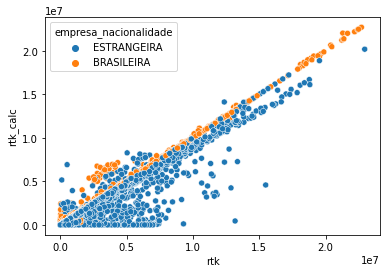

In [8]:
sns.scatterplot(x=df['rtk'],y=df['rtk_calc'],hue=df['empresa_nacionalidade'])

We can see clearly that the line y=x has many Brazilian airlines into it, but not foreign. Also, there is a second line below the y=x line, suggesting a different tendency for some foreign airlines.

Let's improve the optimization problem by considering this fact. The optimization function defined above will be split in two: one to optimize the weight for Brazilian airlines and the other one for foreign airlines.

In [9]:
def matching_br(k):
    
    dummy = []
    for index, x in df[df['empresa_nacionalidade']=='BRASILEIRA'].iterrows():
        if x['decolagens'] == 0:
            dummy.append(abs(x['rtk']) < 1000)
        else:
            dummy.append(abs(x['rtk'] - (k*x['passageiros_pagos']+x['carga_paga_kg']+x['correio_kg']+x['bagagem_kg'])*x['distancia_voada_km']/
                             (1000*x['decolagens'])) < 1000)
    return 1/sum(dummy)

def matching_frgn(k):
    
    dummy = []
    for index, x in df[df['empresa_nacionalidade']=='ESTRANGEIRA'].iterrows():
        if x['decolagens'] == 0:
            dummy.append(abs(x['rtk']) < 1000)
        else:
            dummy.append(abs(x['rtk'] - (k*x['passageiros_pagos']+x['carga_paga_kg']+x['correio_kg']+x['bagagem_kg'])*x['distancia_voada_km']/
                             (1000*x['decolagens'])) < 1000)
    return 1/sum(dummy)


res_br = optimize.minimize_scalar(matching_br, bounds=(70,150), method='bounded',
                                options={'maxiter':100})

print(res_br)

res_frgn = optimize.minimize_scalar(matching_frgn, bounds=(70,150), method='bounded',
                                options={'maxiter':100})

print(res_frgn)

     fun: 2.5802456393848696e-05
 message: 'Solution found.'
    nfev: 27
  status: 0
 success: True
       x: 75.00044845613596
     fun: 0.00028669724770642203
 message: 'Solution found.'
    nfev: 22
  status: 0
 success: True
       x: 90.0005090318264


By optimizing the error between RKT and calculated RTK for Brazilian airlines and foreign airlines separately, we arrive at the following values:
- Brazilian airlines have 75kg as the best average value for passenger weight;
- Foreign airlines have 90kg as the best average value for passenger weight.

With this knowledge, let's calculate again the RTK:

In [10]:
dummy = []
rtk_calc = []
for index, x in df.iterrows():
    if x['empresa_nacionalidade'] == 'BRASILEIRA':
        avgw = 75
    elif x['empresa_nacionalidade'] == 'ESTRANGEIRA':
        avgw = 90
        
    if x['decolagens'] == 0:
        rtk = float('NaN')
        dummy.append(abs(x['rtk']) < 1000)
    else:
        rtk = (avgw*x['passageiros_pagos']+x['carga_paga_kg']+x['correio_kg']+x['bagagem_kg']
           )*x['distancia_voada_km']/(1000*x['decolagens'])
        dummy.append(abs(x['rtk'] - rtk) < 1000)
    rtk_calc.append(rtk)

print('The number of rtk values that correspond to rtk calculation is: {:.2f}%'.format(100*sum(dummy)/len(dummy)))
df['rtk_calc'] = rtk_calc

del dummy, rtk_calc, rtk

The number of rtk values that correspond to rtk calculation is: 58.90%


We see now that the match of RTK values passed from 56.28% to 58.90%. Let's also reprint the previous graphic with the corrected calculated RTK.

<AxesSubplot:xlabel='rtk', ylabel='rtk_calc'>

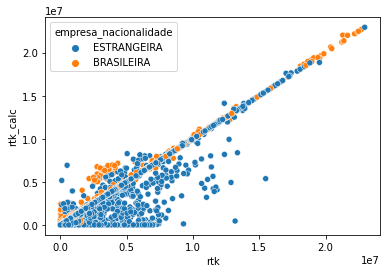

In [11]:
sns.scatterplot(x=df['rtk'],y=df['rtk_calc'],hue=df['empresa_nacionalidade'])

We can see that the second tendency line is gone, since we have took into consideration its behaviour in our model.

It would be very interesting to find other behaviors to use in this optimization problem. Other variables, however, are not clearly related to clusters in the model to account for their use.

Out of curiosity, let's check a few examples.

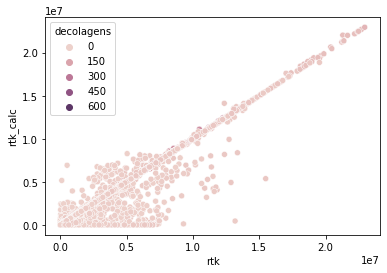

In [20]:
ax = sns.scatterplot(x=df['rtk'],y=df['rtk_calc'],hue=df['decolagens'])

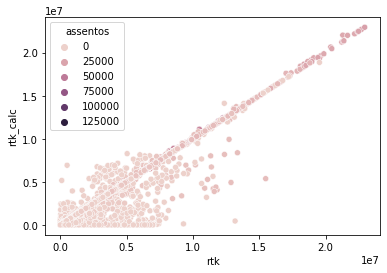

In [22]:
ax = sns.scatterplot(x=df['rtk'],y=df['rtk_calc'],hue=df['assentos'])

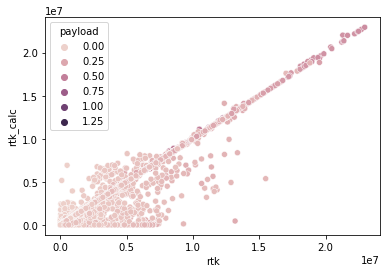

In [23]:
ax = sns.scatterplot(x=df['rtk'],y=df['rtk_calc'],hue=df['payload'])

As Data Scientists, we should verify we have questioned all our assumptions and made all the cross-checkings before accepting a model as the best outcome possible.

When problems similar to this are presented, the Scipy is an excellent tool, being able to solve even more complex problems.

Don't forget to check the article in which the other data of this data set is explored, and we verify the airports most affected by travel restrictions in 2020. The link is:

# LINK TO THE OTHER ARTICLE

See you there!